<a href="https://colab.research.google.com/github/5AF1/Pioneer-Alpha/blob/main/task1/NER_Spacy.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Task1

Prepare a Name Entity recognition model (using spacy) which can detect food names from text.

# Cloning the repo

The repo contains the primary training data as well.

In [ ]:
! git clone --recursive https://github.com/5AF1/Pioneer-Alpha.git

Cloning into 'Pioneer-Alpha'...
remote: Enumerating objects: 93, done.
remote: Counting objects: 100% (28/28), done.
remote: Compressing objects: 100% (10/10), done.
remote: Total 93 (delta 20), reused 23 (delta 18), pack-reused 65
Unpacking objects: 100% (93/93), done.
Submodule 'task3/catr' (https://github.com/5AF1/catr) registered for path 'task3/catr'
Cloning into '/content/Pioneer-Alpha/task3/catr'...
remote: Enumerating objects: 143, done.        
remote: Counting objects: 100% (86/86), done.        
remote: Compressing objects: 100% (50/50), done.        
remote: Total 143 (delta 60), reused 48 (delta 36), pack-reused 57        
Receiving objects: 100% (143/143), 3.05 MiB | 24.80 MiB/s, done.
Resolving deltas: 100% (65/65), done.
Submodule path 'task3/catr': checked out 'f096715745a4c6a21bccaac82b5085511d900e38'


# Installing the en_core_web_lg model

In [ ]:
# download spacy language model
!python -m spacy download en_core_web_lg

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 400.7 MB 7.7 kB/s 
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_lg')


# Basic imports

In [ ]:
# import libraries
import en_core_web_lg
import pandas as pd
import re
import random
import spacy
from spacy.util import minibatch, compounding
import warnings
import matplotlib.pyplot as plt

from pathlib import Path
import os

# Loading the csv file for our primary data

In [ ]:
csv_path = Path('/content/Pioneer-Alpha/task1/Data')
os.listdir(csv_path)

['bangla_foods.csv', 'food.csv', 'npr.csv']

In [ ]:
# read in the food csv file
food_df = pd.read_csv(csv_path/"food.csv")

# print row and column information
food_df.head()
len(food_df.description.unique())

212483

In [ ]:
# print the size 
food_df["description"].size

354565

# Dataset size reduction
As we can see the dataset is huge. So to reduce the size We will 
- Filter out names with special characters (+,&, !, , and so on).
- Remove names with more than three words

In [ ]:
# diaqualify foods with special characters, lowercase and extract results from "description" column
foods = food_df[food_df["description"].str.contains("[^a-zA-Z ]") == False]["description"].apply(lambda food: food.lower())

# filter out foods with more than 3 words, drop any duplicates
foods = foods[foods.str.split().apply(len) <= 3].drop_duplicates()

# print the remaining size
foods.size

37596

# Count
We see the distribution of the data

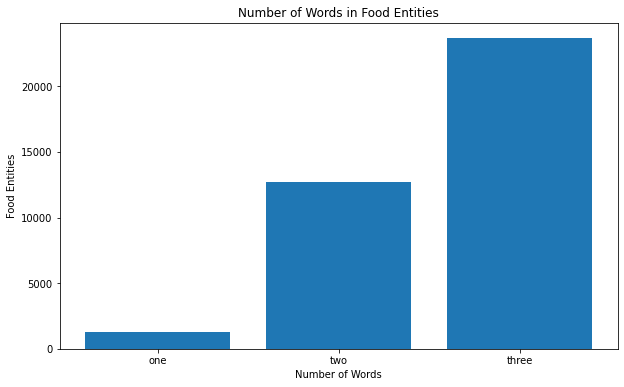

In [ ]:
# find one-worded, two-worded and three-worded foods
one_worded_foods = foods[foods.str.split().apply(len) == 1]
two_worded_foods = foods[foods.str.split().apply(len) == 2]
three_worded_foods = foods[foods.str.split().apply(len) == 3]

# create a bar plot
fig, ax = plt.subplots(figsize=(10, 6))
ax.bar([1, 2, 3], [one_worded_foods.size, two_worded_foods.size, three_worded_foods.size])

# label the x-axis instances
ax.set_xticks([1, 2, 3])
ax.set_xticklabels(["one", "two", "three"])

# set the title and the xy-axis labels
plt.title("Number of Words in Food Entities")
plt.xlabel("Number of Words")
plt.ylabel("Food Entities")

# display the plot
plt.show()

When feeding our training data into spaCy, we want to think about the bias we want spaCy to avoid. A clear bias can be seen here where the three word foods are way way more than the single named foods. We will solve this in the comming code cells.

# Loading a few bangla food items
Here we load a few bangla food item and split the similarly.

In [ ]:
my_food_df = pd.read_csv(csv_path/'bangla_foods.csv')

my_three_worded_foods = my_food_df['3 word'].str.strip().dropna()
my_two_worded_foods = pd.concat([my_food_df['2 word 1 food'].str.strip(),my_food_df['2 word both food'].str.strip()],ignore_index=True).dropna().drop_duplicates()

temp = my_food_df["2 word both food"].str.split(" ", n = 1, expand = True).dropna()
my_one_worded_foods =  pd.concat([my_food_df['1 word 1 food'].str.strip(),temp[0].str.strip(),temp[1].str.strip()],ignore_index=True).drop_duplicates().dropna()
my_one_worded_foods,my_two_worded_foods,my_three_worded_foods

(0       Jhalmuri
 1         Payesh
 2         Haleem
 3      Chorchori
 4     Roshogolla
 5     Rossomalai
 6          Pitha
 7         Shemai
 8       Shingara
 9         Fuchka
 10       Paratha
 11         Luchi
 12      Chomchom
 13        Jilapi
 14         Laddu
 15          Puri
 16          Ruti
 17      Shandesh
 18        Tehari
 19      Khichuri
 20        Bhorta
 21       Borhani
 22        Nehari
 23         Kabab
 24        Beguni
 25    Bakorkhani
 26         Korma
 27          Naan
 28        Pakora
 29       Falooda
 30       Shorshe
 31         Panta
 33        Kacchi
 34        Mutton
 35         Morog
 36        Masoor
 37        Mishti
 38           Doi
 39       Mughlai
 41         Begun
 42           Alu
 43           Lau
 45           Dal
 46        Shutki
 48          Aloo
 49         Ilish
 50          bhat
 52       Biryani
 54         Polao
 57         Chira
 62       Chingri
 63           doi
 67         Potol
 dtype: object, 0       Bhuna Khichuri
 1     

## A distribution of the data

My One worded food count: 53
My Two worded food count: 36
My Three worded food count: 4


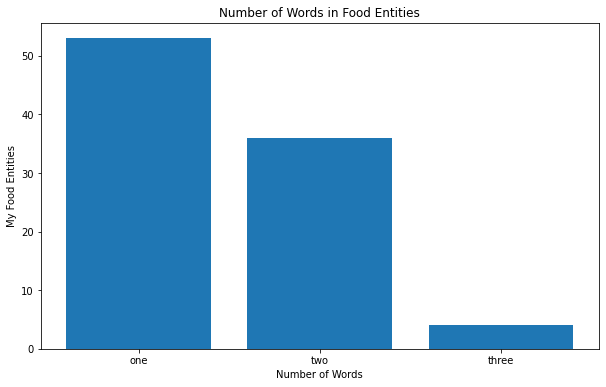

In [ ]:
print(f'My One worded food count: {len(my_one_worded_foods)}')
print(f'My Two worded food count: {len(my_two_worded_foods)}')
print(f'My Three worded food count: {len(my_three_worded_foods)}')
# create a bar plot
fig, ax = plt.subplots(figsize=(10, 6))
ax.bar([1, 2, 3], [my_one_worded_foods.size, my_two_worded_foods.size, my_three_worded_foods.size])

# label the x-axis instances
ax.set_xticks([1, 2, 3])
ax.set_xticklabels(["one", "two", "three"])

# set the title and the xy-axis labels
plt.title("Number of Words in Food Entities")
plt.xlabel("Number of Words")
plt.ylabel("My Food Entities")

# display the plot
plt.show()

# Tackling the bias

Because the majority of our food entities are multi-worded, spaCy would develop a bias for multi-worded foods. If we look back to our example of grilled cheese, it's not a big deal if spaCy identifies cheese instead of grilled cheese. It is a big deal if spaCy fails to identify cheese at all.

So we only take 45% of the original one word data. 30% of of the original two word data and 25% of the original three word data.

In [ ]:
# total number of foods
total_num_foods = round(one_worded_foods.size / 45 * 100)

# shuffle the 2-worded and 3-worded foods since we'll be slicing them
two_worded_foods = two_worded_foods.sample(frac=1)
three_worded_foods = three_worded_foods.sample(frac=1)

# append the foods together 
foods = one_worded_foods.append(two_worded_foods[:round(total_num_foods * 0.30)]).append(three_worded_foods[:round(total_num_foods * 0.25)])

# print the resulting sizes
for i in range(3):
    print(f"{i+1}-worded food entities:", foods[foods.str.split().apply(len) == i + 1].size)

1-worded food entities: 1258
2-worded food entities: 839
3-worded food entities: 699


Now we add the small custom dataset for Bangla foods. We take all of the data in this case as One and two words are higher in our case.

In [ ]:
# append my foods also
foods = foods.append(my_one_worded_foods).append(my_two_worded_foods).append(my_three_worded_foods)

# print the resulting sizes
for i in range(3):
    print(f"{i+1}-worded food entities: {foods[foods.str.split().apply(len) == i + 1].size}")

1-worded food entities: 1311
2-worded food entities: 875
3-worded food entities: 703


# Food templates

In [ ]:
food_templates = [
    "I ate my {}",
    "I'm eating a {}",
    "I just ate a {}",
    "I only ate the {}",
    "I'm done eating a {}",
    "I've already eaten a {}",
    "I just finished my {}",
    "When I was having lunch I ate a {}",
    "I had a {} and a {} today",
    "I ate a {} and a {} for lunch",
    "I made a {} and {} for lunch",
    "I ate {} and {}",
    "today I ate a {} and a {} for lunch",
    "I had {} with my husband last night",
    "I brought you some {} on my birthday",
    "I made {} for yesterday's dinner",
    "last night, a {} was sent to me with {}",
    "I had {} yesterday and I'd like to eat it anyway",
    "I ate a couple of {} last night",
    "I had some {} at dinner last night",
    "Last night, I ordered some {}",
    "I made a {} last night",
    "I had a bowl of {} with {} and I wanted to go to the mall today",
    "I brought a basket of {} for breakfast this morning",
    "I had a bowl of {}",
    "I ate a {} with {} in the morning",
    "I made a bowl of {} for my breakfast",
    "There's {} for breakfast in the bowl this morning",
    "This morning, I made a bowl of {}",
    "I decided to have some {} as a little bonus",
    "I decided to enjoy some {}",
    "I've decided to have some {} for dessert",
    "I had a {}, a {} and {} at home",
    "I took a {}, {} and {} on the weekend",
    "I ate a {} with {} and {} just now",
    "Last night, I ate an {} with {} and {}",
    "I tasted some {}, {} and {} at the office",
    "There's a basket of {}, {} and {} that I consumed",
    "I devoured a {}, {} and {}",
    "I've already had a bag of {}, {} and {} from the fridge"
]

# Splitting the data for training and testing

In [ ]:
# create dictionaries to store the generated food combinations. Do note that one_food != one_worded_food. one_food == "barbecue sauce", one_worded_food == "sauce"
TRAIN_FOOD_DATA = {
    "one_food": [],
    "two_foods": [],
    "three_foods": []
}

TEST_FOOD_DATA = {
    "one_food": [],
    "two_foods": [],
    "three_foods": []
}

# one_food, two_food, and three_food combinations will be limited to 167 sentences
FOOD_SENTENCE_LIMIT = 167

# helper function for deciding what dictionary and subsequent array to append the food sentence on to
def get_food_data(count):
    return {
        1: TRAIN_FOOD_DATA["one_food"] if len(TRAIN_FOOD_DATA["one_food"]) < FOOD_SENTENCE_LIMIT else TEST_FOOD_DATA["one_food"],
        2: TRAIN_FOOD_DATA["two_foods"] if len(TRAIN_FOOD_DATA["two_foods"]) < FOOD_SENTENCE_LIMIT else TEST_FOOD_DATA["two_foods"],
        3: TRAIN_FOOD_DATA["three_foods"] if len(TRAIN_FOOD_DATA["three_foods"]) < FOOD_SENTENCE_LIMIT else TEST_FOOD_DATA["three_foods"],
    }[count]

# the pattern to replace from the template sentences
pattern_to_replace = "{}"

# shuffle the data before starting
foods = foods.sample(frac=1)

# the count that helps us decide when to break from the for loop
food_entity_count = foods.size - 1

# start the while loop, ensure we don't get an index out of bounds error
while food_entity_count >= 2:
    entities = []

    # pick a random food template
    sentence = food_templates[random.randint(0, len(food_templates) - 1)]

    # find out how many braces "{}" need to be replaced in the template
    matches = re.findall(pattern_to_replace, sentence)

    # for each brace, replace with a food entity from the shuffled food data
    for match in matches:
        food = foods.iloc[food_entity_count]
        food_entity_count -= 1

        # replace the pattern, but then find the match of the food entity we just inserted
        sentence = sentence.replace(match, food, 1)
        match_span = re.search(food, sentence).span()

        # use that match to find the index positions of the food entity in the sentence, append
        entities.append((match_span[0], match_span[1], "FOOD"))

    # append the sentence and the position of the entities to the correct dictionary and array
    get_food_data(len(matches)).append((sentence, {"entities": entities}))

In [ ]:
# print the number of food sentences, as well as an example sentence
for key in TRAIN_FOOD_DATA:
    print("{} {} sentences: {}".format(len(TRAIN_FOOD_DATA[key]), key, TRAIN_FOOD_DATA[key][0]))

167 one_food sentences: ('I ate a couple of oat crisps cereal last night', {'entities': [(18, 35, 'FOOD')]})
167 two_foods sentences: ('last night, a filled pretzel sandwiches was sent to me with classic cookies', {'entities': [(14, 39, 'FOOD'), (60, 75, 'FOOD')]})
167 three_foods sentences: ("I've already had a bag of whole tilapia, pizza halves and estafiate from the fridge", {'entities': [(26, 39, 'FOOD'), (41, 53, 'FOOD'), (58, 67, 'FOOD')]})


# Preparing the revision data

In [ ]:
# read in the revision data 
npr_df = pd.read_csv(csv_path/"npr.csv")

# print row and column information
npr_df.head()

,Article
0,"In the Washington of 2016, even when the polic..."
1,Donald Trump has used Twitter — his prefe...
2,Donald Trump is unabashedly praising Russian...
3,"Updated at 2:50 p. m. ET, Russian President Vl..."
4,"From photography, illustration and video, to d..."


# Loading the nlp model

In [ ]:
# create an nlp object as we'll use this to seperate the sentences and identify existing entities
nlp = en_core_web_lg.load()

## Convert the articles to spacy objects

In [ ]:
revision_texts = []

# convert the articles to spacy objects to better identify the sentences. Disabled unneeded components. # takes ~ 7 minutes
for doc in nlp.pipe(npr_df["Article"][:6000], batch_size=30, disable=["tagger", "ner"]):
    for sentence in doc.sents:
        if  40 < len(sentence.text) < 80:
            # some of the sentences had excessive whitespace in between words, so we're trimming that
            revision_texts.append(" ".join(re.split("\s+", sentence.text, flags=re.UNICODE)))

/usr/local/lib/python3.7/dist-packages/spacy/pipeline/lemmatizer.py:211: UserWarning: [W108] The rule-based lemmatizer did not find POS annotation for one or more tokens. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
  warnings.warn(Warnings.W108)


# Use the existing spaCy model to predict entities

In [ ]:
revisions = []

# Use the existing spaCy model to predict the entities, then append them to revision
for doc in nlp.pipe(revision_texts, batch_size=50, disable=["tagger", "parser"]):
    
    # don't append sentences that have no entities
    if len(doc.ents) > 0:
        revisions.append((doc.text, {"entities": [(e.start_char, e.end_char, e.label_) for e in doc.ents]}))

/usr/local/lib/python3.7/dist-packages/spacy/pipeline/lemmatizer.py:211: UserWarning: [W108] The rule-based lemmatizer did not find POS annotation for one or more tokens. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
  warnings.warn(Warnings.W108)


In [ ]:
# print an example of the revision sentence
print(revisions[0][0])

# print an example of the revision data
print(revisions[0][1])

And in that sense, this year shows little sign of ending on Dec. 31.
{'entities': [(19, 28, 'DATE'), (60, 67, 'DATE')]}


# Loading the data to list and doing a count

In [ ]:
# create arrays to store the revision data
TRAIN_REVISION_DATA = []
TEST_REVISION_DATA = []

# create dictionaries to keep count of the different entities
TRAIN_ENTITY_COUNTER = {}
TEST_ENTITY_COUNTER = {}

# This will help distribute the entities (i.e. we don't want 1000 PERSON entities, but only 80 ORG entities)
REVISION_SENTENCE_SOFT_LIMIT = 100

# helper function for incrementing the revision counters
def increment_revision_counters(entity_counter, entities):
    for entity in entities:
        label = entity[2]
        if label in entity_counter:
            entity_counter[label] += 1
        else:
            entity_counter[label] = 1

random.shuffle(revisions)
for revision in revisions:
    # get the entities from the revision sentence
    entities = revision[1]["entities"]

    # simple hack to make sure spaCy entities don't get too one-sided
    should_append_to_train_counter = 0
    for _, _, label in entities:
        if label in TRAIN_ENTITY_COUNTER and TRAIN_ENTITY_COUNTER[label] > REVISION_SENTENCE_SOFT_LIMIT:
            should_append_to_train_counter -= 1
        else:
            should_append_to_train_counter += 1

    # simple switch for deciding whether to append to train data or test data
    if should_append_to_train_counter >= 0:
        TRAIN_REVISION_DATA.append(revision)
        increment_revision_counters(TRAIN_ENTITY_COUNTER, entities)
    else:
        TEST_REVISION_DATA.append(revision)
        increment_revision_counters(TEST_ENTITY_COUNTER, entities)

In [ ]:
TRAIN_ENTITY_COUNTER

{'CARDINAL': 160,
 'DATE': 214,
 'EVENT': 101,
 'FAC': 101,
 'GPE': 166,
 'LANGUAGE': 57,
 'LAW': 53,
 'LOC': 104,
 'MONEY': 104,
 'NORP': 121,
 'ORDINAL': 109,
 'ORG': 189,
 'PERCENT': 102,
 'PERSON': 274,
 'PRODUCT': 101,
 'QUANTITY': 101,
 'TIME': 105,
 'WORK_OF_ART': 103}

In [ ]:
TEST_ENTITY_COUNTER

{'CARDINAL': 4097,
 'DATE': 6072,
 'EVENT': 91,
 'FAC': 109,
 'GPE': 4801,
 'LANGUAGE': 16,
 'LAW': 7,
 'LOC': 446,
 'MONEY': 439,
 'NORP': 2297,
 'ORDINAL': 1025,
 'ORG': 7141,
 'PERCENT': 420,
 'PERSON': 12406,
 'PRODUCT': 144,
 'QUANTITY': 76,
 'TIME': 609,
 'WORK_OF_ART': 302}

# Combining with the food data 

In [ ]:
# combine the food training data
TRAIN_FOOD_DATA_COMBINED = TRAIN_FOOD_DATA["one_food"] + TRAIN_FOOD_DATA["two_foods"] + TRAIN_FOOD_DATA["three_foods"]

# print the length of the food training data
print("FOOD", len(TRAIN_FOOD_DATA_COMBINED))

# print the length of the revision training data
print("REVISION", len(TRAIN_REVISION_DATA))

# join and print the combined length
TRAIN_DATA = TRAIN_REVISION_DATA + TRAIN_FOOD_DATA_COMBINED
print("COMBINED", len(TRAIN_DATA))

FOOD 501
REVISION 1462
COMBINED 1963


# Training the model

In [ ]:
from spacy.training.example import Example

# add NER to the pipeline and the new label
ner = nlp.get_pipe("ner")
ner.add_label("FOOD")

# get the names of the components we want to disable during training
pipe_exceptions = ["ner", "trf_wordpiecer", "trf_tok2vec"]
other_pipes = [pipe for pipe in nlp.pipe_names if pipe not in pipe_exceptions]

# start the training loop, only training NER
epochs = 30
optimizer = nlp.resume_training()
with nlp.disable_pipes(*other_pipes), warnings.catch_warnings():
    warnings.filterwarnings("once", category=UserWarning, module='spacy')
    sizes = compounding(1.0, 4.0, 1.001)
    
    # batch up the examples using spaCy's minibatc
    for epoch in range(epochs):
        examples = TRAIN_DATA
        random.shuffle(examples)
        batches = minibatch(examples, size=sizes)
        losses = {}
        
        for batch in batches:
            texts, annotations = zip(*batch)
            #print(annotations)
            doc = nlp.make_doc(texts[0])
            example = Example.from_dict(doc,annotations[0])

            #nlp.update(texts, annotations, sgd=optimizer, drop=0.35, losses=losses)
            nlp.update([example], sgd=optimizer, drop=0.35, losses=losses)

        print("Losses ({}/{})".format(epoch + 1, epochs), losses)

Losses (1/30) {'ner': 1921.8869533970394}
Losses (2/30) {'ner': 517.3137816240749}
Losses (3/30) {'ner': 537.0420793917998}
Losses (4/30) {'ner': 492.5556143169676}
Losses (5/30) {'ner': 493.95220941106646}
Losses (6/30) {'ner': 493.95176611091756}
Losses (7/30) {'ner': 443.03186111934787}
Losses (8/30) {'ner': 482.7560203280503}
Losses (9/30) {'ner': 455.1444317926811}
Losses (10/30) {'ner': 417.03002893877556}
Losses (11/30) {'ner': 448.675849496099}
Losses (12/30) {'ner': 425.07843330645625}
Losses (13/30) {'ner': 403.2260589172585}
Losses (14/30) {'ner': 358.01999993040226}
Losses (15/30) {'ner': 421.32027297649444}
Losses (16/30) {'ner': 345.549469396799}
Losses (17/30) {'ner': 429.96644246638505}
Losses (18/30) {'ner': 373.53846692526787}
Losses (19/30) {'ner': 413.9302740558205}
Losses (20/30) {'ner': 380.7246598054624}
Losses (21/30) {'ner': 341.46156505427075}
Losses (22/30) {'ner': 334.23468170658145}
Losses (23/30) {'ner': 340.349550306281}
Losses (24/30) {'ner': 366.4571647

# Testing the model

In [ ]:
# display sentence involving original entities
spacy.displacy.render(nlp("Apple is looking at buying U.K. startup for $1 billion"), style="ent", jupyter=True, options={'distance': 90})
spacy.displacy.render(nlp("An apple a day keeps the doctor away."), style="ent", jupyter=True, options={'distance': 90})

/usr/local/lib/python3.7/dist-packages/spacy/displacy/__init__.py:205: UserWarning: [W006] No entities to visualize found in Doc object. If this is surprising to you, make sure the Doc was processed using a model that supports named entity recognition, and check the `doc.ents` property manually if necessary.
  warnings.warn(Warnings.W006)


In [ ]:
# display sentences involving target entity
spacy.displacy.render(nlp("I had an Apple and chips for lunch today."), style="ent", jupyter=True)
spacy.displacy.render(nlp("I decided to have chocolate ice cream as a little treat for myself."), style="ent", jupyter=True)
spacy.displacy.render(nlp("I ordered basmati rice, leaf spinach and cheese from Agora yesterday"), style="ent", jupyter=True)

/usr/local/lib/python3.7/dist-packages/spacy/displacy/__init__.py:205: UserWarning: [W006] No entities to visualize found in Doc object. If this is surprising to you, make sure the Doc was processed using a model that supports named entity recognition, and check the `doc.ents` property manually if necessary.
  warnings.warn(Warnings.W006)


In [ ]:
spacy.displacy.render(nlp("I ordered some porota from the store yesterday"), style="ent", jupyter=True)
spacy.displacy.render(nlp("I like both porota and polao."), style="ent", jupyter=True)


In [ ]:
# dictionary to hold our evaluation data
food_evaluation = {
    "one_food": {
        "correct": 0,
        "total": 0,
    },
    "two_foods": {
        "correct": 0,
        "total": 0
    },
    "three_foods": {
        "correct": 0,
        "total": 0
    }
}

word_evaluation = {
    "1_worded_foods": {
        "correct": 0,
        "total": 0
    },
    "2_worded_foods": {
        "correct": 0,
        "total": 0
    },
    "3_worded_foods": {
        "correct": 0,
        "total": 0
    }
}

# loop over data from our test food set (3 keys in total)
for key in TEST_FOOD_DATA:
    foods = TEST_FOOD_DATA[key]

    for food in foods:
        # extract the sentence and correct food entities according to our test data
        sentence = food[0]
        entities = food[1]["entities"]

        # for each entity, use our updated model to make a prediction on the sentence
        for entity in entities:
            doc = nlp(sentence)
            correct_text = sentence[entity[0]:entity[1]]
            n_worded_food =  len(correct_text.split())

            # if we find that there's a match for predicted entity and predicted text, increment correct counters
            for ent in doc.ents:
                if ent.label_ == entity[2] and ent.text == correct_text:
                    food_evaluation[key]["correct"] += 1
                    if n_worded_food > 0:
                        word_evaluation[f"{n_worded_food}_worded_foods"]["correct"] += 1
                    
                    # this break is important, ensures that we're not double counting on a correct match
                    break
            
            #  increment total counters after each entity loop
            food_evaluation[key]["total"] += 1
            if n_worded_food > 0:
                word_evaluation[f"{n_worded_food}_worded_foods"]["total"] += 1

In [ ]:
for key in word_evaluation:
    correct = word_evaluation[key]["correct"]
    total = word_evaluation[key]["total"]

    print(f"{key}: {correct / total * 100:.2f}%")

food_total_sum = 0
food_correct_sum = 0

print("---")
for key in food_evaluation:
    correct = food_evaluation[key]["correct"]
    total = food_evaluation[key]["total"]
    
    food_total_sum += total
    food_correct_sum += correct

    print(f"{key}: {correct / total * 100:.2f}%")

print(f"\nTotal: {food_correct_sum/food_total_sum * 100:.2f}%")

1_worded_foods: 98.11%
2_worded_foods: 94.89%
3_worded_foods: 94.06%
---
one_food: 95.67%
two_foods: 96.47%
three_foods: 96.63%

Total: 96.13%


In [ ]:
# dictionary which will be populated with the entities and result information
entity_evaluation = {}

# helper function to udpate the entity_evaluation dictionary
def update_results(entity, metric):
    if entity not in entity_evaluation:
        entity_evaluation[entity] = {"correct": 0, "total": 0}
    
    entity_evaluation[entity][metric] += 1

# same as before, see if entities from test set match what spaCy currently predicts
for data in TEST_REVISION_DATA:
    sentence = data[0]
    entities = data[1]["entities"]

    for entity in entities:
        doc = nlp(sentence)
        correct_text = sentence[entity[0]:entity[1]]

        for ent in doc.ents:
            if ent.label_ == entity[2] and ent.text == correct_text:
                update_results(ent.label_, "correct")
                break

        update_results(entity[2], "total")

In [ ]:
sum_total = 0
sum_correct = 0

for entity in entity_evaluation:
    total = entity_evaluation[entity]["total"]
    correct = entity_evaluation[entity]["correct"]

    sum_total += total
    sum_correct += correct
    
    print("{} | {:.2f}%".format(entity, correct / total * 100))

print()
print("Overall accuracy: {:.2f}%".format(sum_correct / sum_total * 100))

PERSON | 82.80%
DATE | 79.12%
ORG | 47.50%
GPE | 86.79%
ORDINAL | 95.22%
NORP | 92.42%
CARDINAL | 83.06%
WORK_OF_ART | 57.28%
FAC | 76.15%
PRODUCT | 79.17%
PERCENT | 94.29%
LOC | 75.78%
MONEY | 78.82%
TIME | 68.31%
LAW | 71.43%
QUANTITY | 82.89%
EVENT | 68.13%
LANGUAGE | 87.50%

Overall accuracy: 76.91%


# Saving the model

In [ ]:
nlp.meta["name"] = "food_entity_extractor_v2"
nlp.to_disk(csv_path)

The blog [Training spaCy's NER Model to Identify Food Entities](https://deepnote.com/@isaac-aderogba/Spacy-Food-Entities-2cc2d19c-c3ac-4321-8853-0bcf2ef565b3)
 was followed to slove the problem of the task.
# Thank you